## Data

Industrial Production: Manufacturing: Non-Durable Goods: Ice Cream and Frozen Dessert

Info about this data set: https://fred.stlouisfed.org/series/IPN31152N

Frequency:  Monthly

The industrial production (IP) index measures the real output of all relevant establishments located in the United States, regardless of their ownership, but not those located in U.S. territories.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Let's read our data, make necessary changes (set the date to a datetime index and change the column name) and plot**

In [2]:
df = pd.read_csv('../DATA/Frozen_Dessert_Production.csv', parse_dates=True, index_col='DATE')

In [3]:
df.columns = ['Production']

In [4]:
df.head()

,Production
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


<AxesSubplot:xlabel='DATE'>

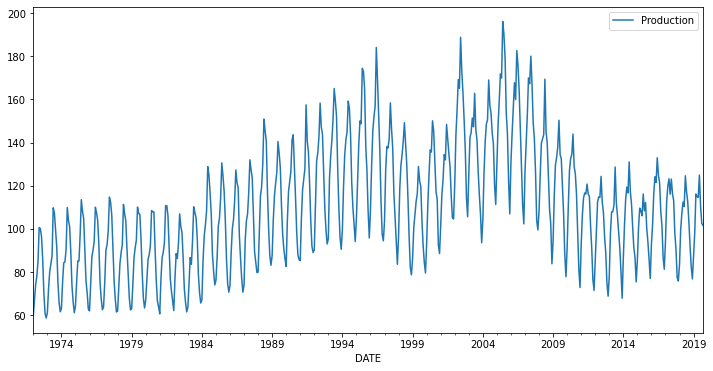

In [5]:
df.plot(figsize=(12,6))

## Train Test Split

**Let's split the data into a train/test split where the test set is the last 24 months of data.**

In [6]:
test_size = 18

In [7]:
train = df.iloc[:-test_size]

In [8]:
test = df.iloc[-test_size:]

## Scale Data

**Let's use a MinMaxScaler to scale the train and test sets into scaled versions.**

In [9]:
from sklearn.preprocessing import MinMaxScaler

In [10]:
scaler = MinMaxScaler()

In [11]:
scaled_train = scaler.fit_transform(train)

In [12]:
scaled_test = scaler.transform(test)

## Time Series Generator (for train set)

In [13]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [14]:
batch_length = 12
n_features = 1

In [15]:
generator = TimeseriesGenerator(scaled_train, scaled_train, length=batch_length, batch_size=1)

## Model

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [35]:
model = Sequential()

In [36]:
model.add(LSTM(150, input_shape=(batch_length, n_features)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [37]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 150)               91200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


**Set Earlystopping and create time series generator for test set**

In [38]:
from tensorflow.keras.callbacks import EarlyStopping

In [39]:
early_stop = EarlyStopping(monitor='val_loss', patience=4)

In [40]:
validation_generator = TimeseriesGenerator(scaled_test, scaled_test, length=batch_length, batch_size=1)

**Fit the model to the generator**

In [41]:
model.fit(generator, epochs=20, validation_data=validation_generator, callbacks=[early_stop])

Epoch 1/20
543/543 [==============================] - 7s 8ms/step - loss: 0.0417 - val_loss: 0.0010
Epoch 2/20
543/543 [==============================] - 4s 8ms/step - loss: 0.0055 - val_loss: 0.0025
Epoch 3/20
543/543 [==============================] - 4s 8ms/step - loss: 0.0042 - val_loss: 0.0028
Epoch 4/20
543/543 [==============================] - 4s 8ms/step - loss: 0.0040 - val_loss: 0.0019
Epoch 5/20
543/543 [==============================] - 4s 8ms/step - loss: 0.0041 - val_loss: 0.0027


**Plot the history of the loss that occured during training.**

In [42]:
results = pd.DataFrame(model.history.history)

<AxesSubplot:>

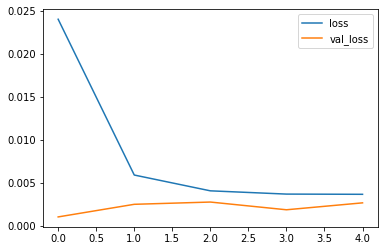

In [43]:
results.plot()

## Evaluate on Test Data

In [44]:
test_predictions = []

current_batch = scaled_train[-batch_length:].reshape((1, batch_length, n_features))

In [45]:
for i in range(len(test)):
    # get prediction 1 time stamp ahead
    current_pred = model.predict(current_batch)[0]
    # store prediction
    test_predictions.append(current_pred)
    # update batch (include current prediction and drop first value)
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)

In [46]:
true_predictions = scaler.inverse_transform(test_predictions)

In [47]:
test['Predictions'] = true_predictions

<ipython-input-47-920b79c3c314>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


In [48]:
test.head()

,Production,Predictions
DATE,,
2018-04-01,112.4309,117.740861
2018-05-01,110.3544,124.267987
2018-06-01,124.5841,127.208847
2018-07-01,117.2215,123.619696
2018-08-01,112.6779,113.617202


<AxesSubplot:xlabel='DATE'>

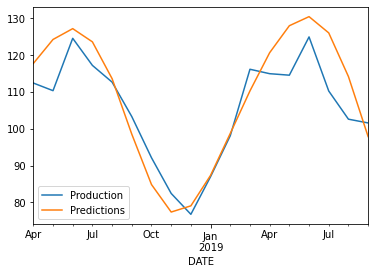

In [49]:
test.plot()

**Calculate your RMSE.**

In [50]:
from sklearn.metrics import mean_squared_error

In [51]:
mean_squared_error(test['Production'], test['Predictions'], squared=False)

7.6484794743970665